# Problem description - Prototype (V0)

## Goal
Have one agent mapping out the environment based on visual input.

Step 1: 2D-case that works
-> RL solves it easily, no doubt about it
-> We want to extend it


Input:
the agent can only see straight ahead








# 2D case

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [251]:
EMPTY = 0
WALL = 1
maze = np.array([[1,1,1,1,1,1],
                 [1,0,0,0,0,1],
                 [1,1,0,1,0,1],
                 [1,1,0,1,0,1],
                 [1,1,0,1,0,1],
                 [1,1,1,1,1,1]])

position = np.array([3,4])

# possible directions - increase clockwise
NORTH = 0
EAST = 1
SOUTH = 2
WEST = 3

direction = WEST

In [271]:
def get_ahead():
    """
    give the array of cells ahead of the agent, including the cell where it stands and the
    furthest wall it sees  
    """
    global maze, position, direction
    assert maze[position[0],position[1]] == EMPTY
    
    if direction == NORTH:
        ahead = maze[position[0]::-1,position[1]]
    elif direction == EAST:
        ahead = maze[position[0],position[1]:]
    elif direction == SOUTH:
        ahead = maze[position[0]:,position[1]]
    elif direction == WEST:
        ahead = maze[position[0],position[1]::-1]
    
    ahead = ahead[:np.where(ahead==WALL)[0][0]+1]
    # distance = len(ahead)-2   # distance to the wall
    return ahead

get_ahead()

array([0, 1])

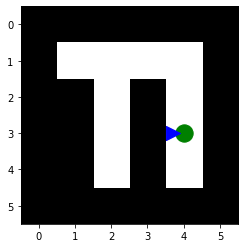

In [253]:
def plot_maze():
    global maze, position, direction
    plt.imshow(~maze, cmap='gray')
    plt.scatter(position[1], position[0], s=300, c='g')
    eye = position + 0.3 * np.array([[-1,0], [0,1],[1,0],[0,-1]])[direction]
    plt.scatter(eye[1], eye[0], s=200, c='b',marker="v<^>"[direction])
    plt.show()
plot_maze()

In [254]:
def rotate(rot):
    global direction
    assert rot in [1,-1], "rotation direction is either -1 (left) or 1 (right)"
    
    direction = (direction + rot) % 4

rotate(1)

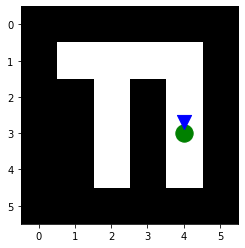

In [255]:
plot_maze()

In [256]:
def move_forward():
    global maze, position, direction
    
    next_pos = position + np.array([[-1,0], [0,1],[1,0],[0,-1]])[direction]
    
    if maze[next_pos[0], next_pos[1]] == 0:
        position = next_pos
    else:
        # hit the wall
        pass
#rotate(1)
#rotate(1)
move_forward()

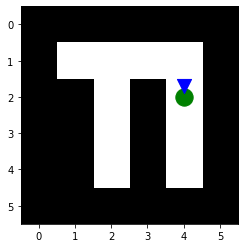

In [257]:
plot_maze()

In [258]:
move_forward()
rotate(-1)
move_forward()
move_forward()
rotate(-1)
move_forward()
move_forward()
rotate(1)
rotate(1)
move_forward()

In [267]:
rotate(-1)

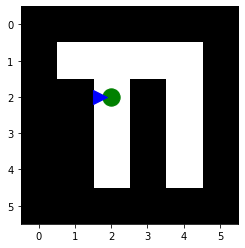

In [268]:
plot_maze()

## Action space

In [260]:
action_space = {
    "left": lambda :rotate(-1),
    "right": lambda :rotate(1),
    "walk": move_forward,
    
}

## State space

In [315]:
def init_state():
    global maze
    UNKNOWN = -1
    size_maze = max(maze.shape)
    known_maze = np.zeros([size_maze,size_maze]) + UNKNOWN
    relative_position = np.array([size_maze//2, size_maze//2]) # start in the middle
    relative_direction = NORTH 
    known_maze[relative_position[0], relative_position[1]] = EMPTY
    state = {
        'maze': known_maze,
        'position': relative_position,
        'direction': relative_direction,
        'ahead': get_ahead()
    }
    return state
state = init_state()

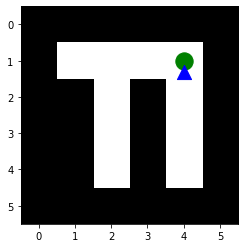

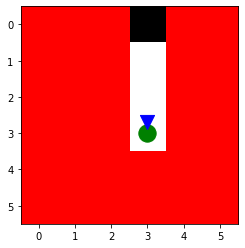

In [382]:
def plot_state(state):
    maze = state['maze']
    position = state['position']
    direction = state['direction']
    maze_plot = 255*np.array([(maze==UNKNOWN)+(maze==EMPTY), # R
                              (maze==EMPTY),                 # G 
                              (maze==EMPTY)],                # B
                             dtype=int)
    plt.imshow(maze_plot.transpose(1,2,0))
    plt.scatter(position[1] % size_maze, position[0] % size_maze, s=300, c='g')
    eye = position % size_maze + 0.3 * np.array([[-1,0], [0,1],[1,0],[0,-1]])[direction]
    plt.scatter(eye[1], eye[0], s=200, c='b',marker="v<^>"[direction])
    plt.show()
plot_maze()
plot_state(state)

## Policy

In [356]:
def get_dist(ahead):
    assert ahead[0] == EMPTY
    assert ahead[-1] == WALL
    # remove agent's position and wall
    return len(ahead)-2

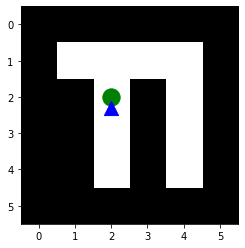

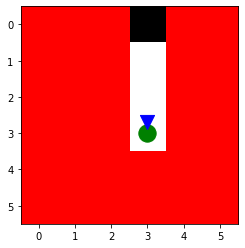

In [333]:
def update_ahead(state):
    """
    Eventually, a neural network will have to learn it
    """
    direction = state["direction"]
    position = state["position"]
    maze = state["maze"]
    
    # Method 1
    def walk(pos, direction):
        # doesn't check if out of map
        return pos + np.array([[-1,0],[0,1],[1,0],[0,-1]])[direction]

    next_pos = position * 1   # creates copy
    dist_ahead = get_dist(state["ahead"])
    for _ in range(dist_ahead):
        next_pos = walk(next_pos,direction) % size_maze
        maze[next_pos[0], next_pos[1]] = EMPTY
    next_pos = walk(next_pos,direction)% size_maze
    maze[next_pos[0], next_pos[1]] = WALL
    
    ## Method 2
    #next_pos = position *1   # creates a copy
    #for c in state["ahead"]:
    #    next_pos = next_pos + np.array([[-1,0],[0,1],[1,0],[0,-1]])[direction]
    #    maze[next_pos[0], next_pos[1]] = c

update_ahead(state)
plot_maze()
plot_state(state)

In [378]:
def update_maze(state, action):
    
    if action == "left":
        state["direction"] = (state["direction"] - 1)%4
    elif action == "right":
        state["direction"] = (state["direction"] + 1)%4
    elif action == "walk":
        next_pos = (state["position"] + np.array([[-1,0],[0,1],[1,0],[0,-1]])[state["direction"]]) % size_maze
        if state["maze"][next_pos[0], next_pos[1]] == EMPTY:
            state["position"] = next_pos
    else:
        print("unknown action")
    state["ahead"] = get_ahead()
    #print(state["ahead"])
    update_ahead(state)

In [374]:
def dumb_strategy_1():
    """
    Walk ahead and turn left when facing a wall
    """
    state = init_state()
    update_ahead(state)
    plot_state(state)
    
    def walk(pos, direction):
        # doesn't check if out of map
        return pos + np.array([[-1,0],[0,1],[1,0],[0,-1]])[direction]
    
    for _ in range(20):
        next_pos = walk(state["position"], state["direction"]) % size_maze
        if state["maze"][next_pos[0],next_pos[1]] == EMPTY:
            print("walk ahead")
            action_space["walk"]()
            update_maze(state, "walk")
        else:
            print("turn left")
            action_space["left"]()
            update_maze(state, "left")
        plot_state(state)

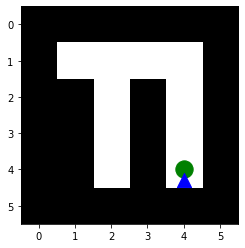

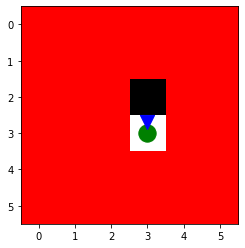

turn left


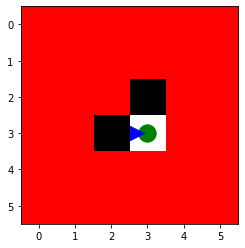

turn left


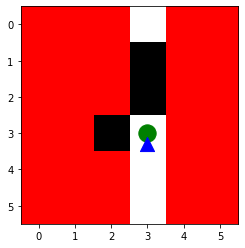

walk ahead


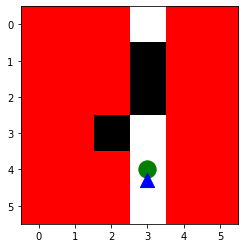

walk ahead


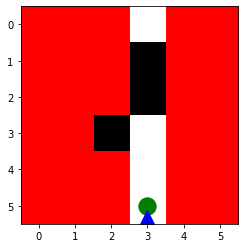

walk ahead


IndexError: index 6 is out of bounds for axis 0 with size 6

In [375]:
plot_maze()
dumb_strategy_1()

In [392]:
def dumb_strategy_2():
    """
    Stick to left wall more or less
    """
    state = init_state()
    update_ahead(state)
    plot_state(state)
    
    def walk(pos, direction):
        # doesn't check if out of map
        return pos + np.array([[-1,0],[0,1],[1,0],[0,-1]])[direction]
    
    for step in range(100):
        print(step, end=". ")
        left_pos = walk(state["position"], (state["direction"]-1)%4) % size_maze
        if state["maze"][left_pos[0], left_pos[1]] != WALL:
            # I'm cheating because I'm taking two actions here
            print("take a left")
            action_space["left"]()
            update_maze(state, "left")
            action_space["walk"]()
            update_maze(state, "walk")
        else:
            next_pos = walk(state["position"], state["direction"]) % size_maze
            if state["maze"][next_pos[0],next_pos[1]] == EMPTY:
                print("walk ahead")
                action_space["walk"]()
                update_maze(state, "walk")
            else:
                print("turn right")
                action_space["right"]()
                update_maze(state, "right")
        plot_state(state)
    
    return state

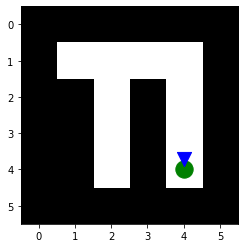

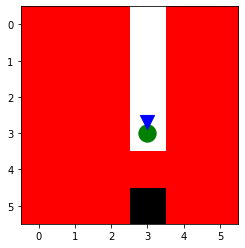

0. take a left


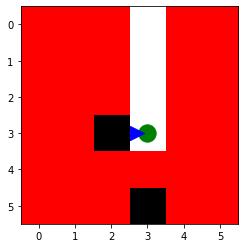

1. take a left


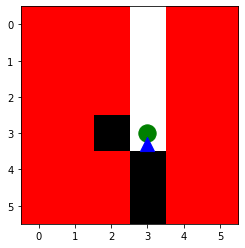

2. take a left


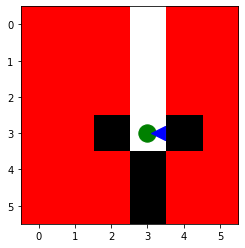

3. take a left


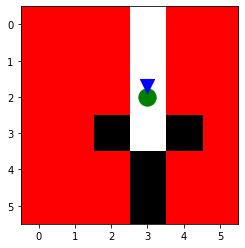

4. take a left


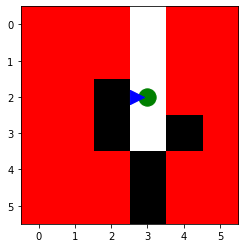

5. take a left


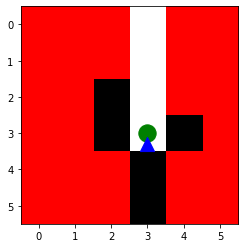

6. turn right


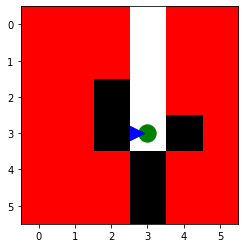

7. turn right


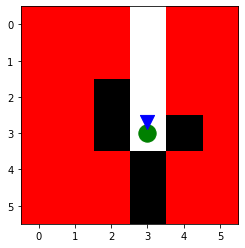

8. walk ahead


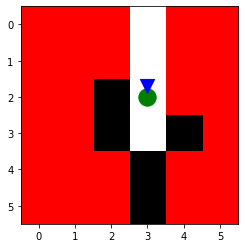

9. walk ahead


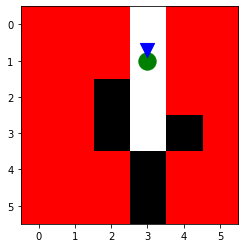

10. take a left


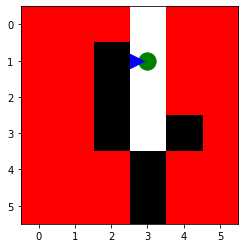

11. take a left


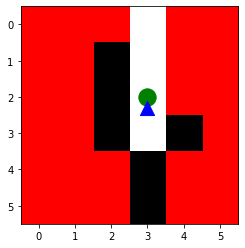

12. take a left


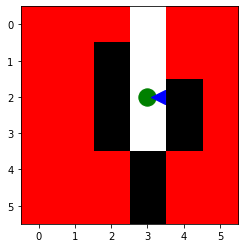

13. take a left


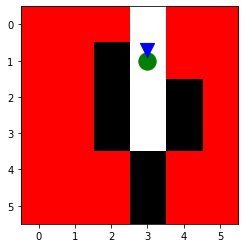

14. walk ahead


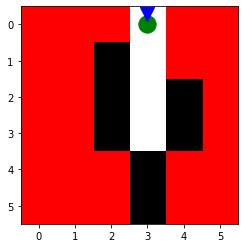

15. take a left


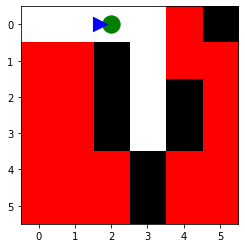

16. walk ahead


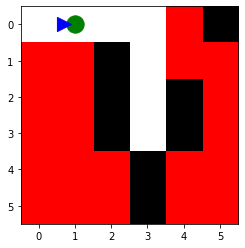

17. take a left


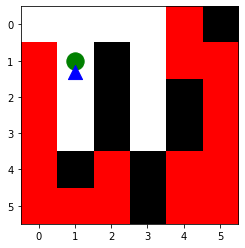

18. walk ahead


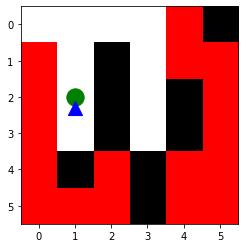

19. walk ahead


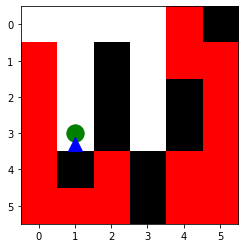

20. turn right


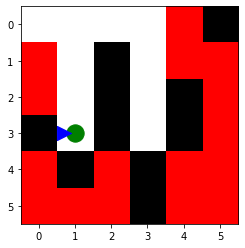

21. turn right


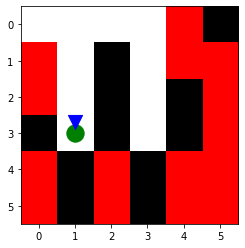

22. walk ahead


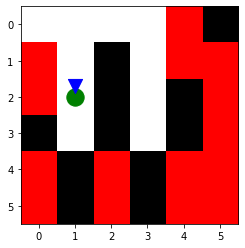

23. take a left


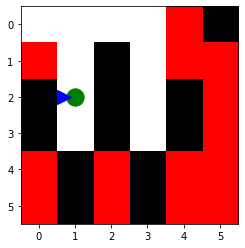

24. take a left


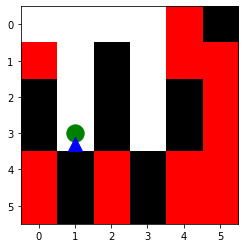

25. turn right


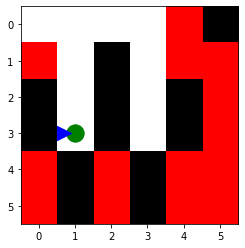

26. turn right


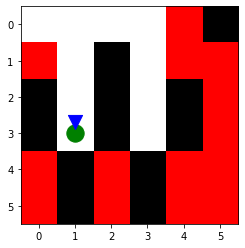

27. walk ahead


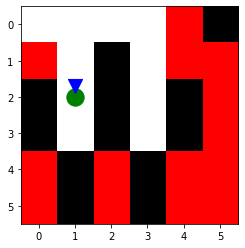

28. walk ahead


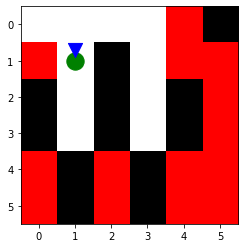

29. take a left


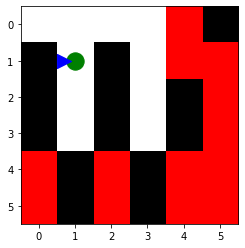

30. take a left


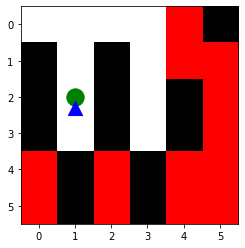

31. walk ahead


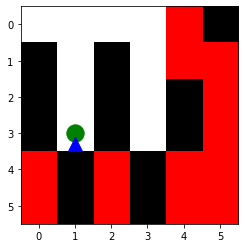

32. turn right


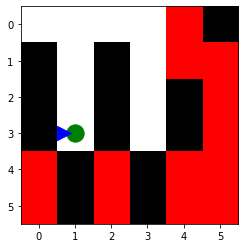

33. turn right


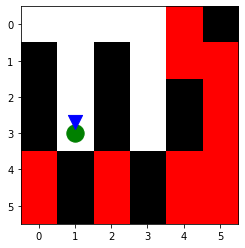

34. walk ahead


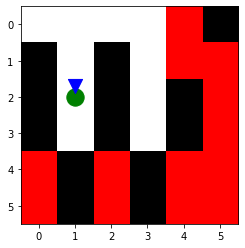

35. walk ahead


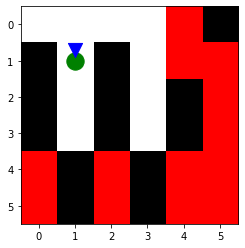

36. walk ahead


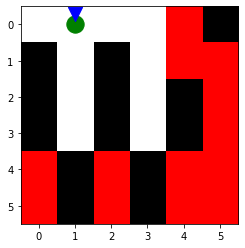

37. take a left


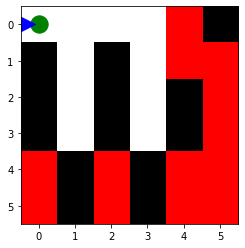

38. turn right


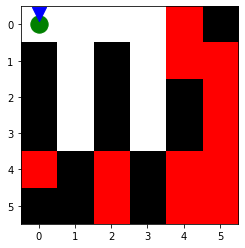

39. turn right


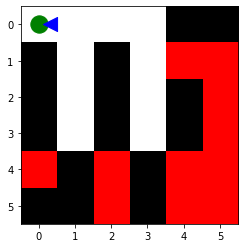

40. walk ahead


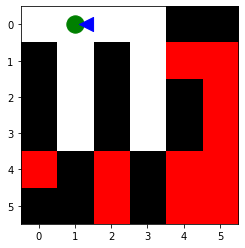

41. walk ahead


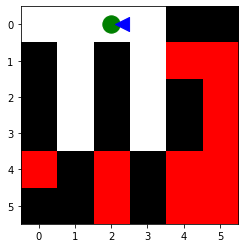

42. take a left


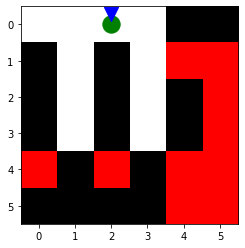

43. take a left


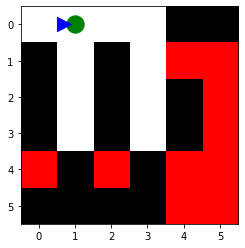

44. take a left


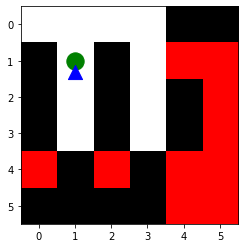

45. walk ahead


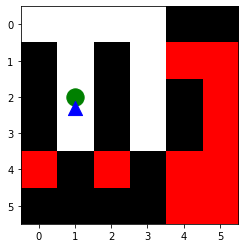

46. walk ahead


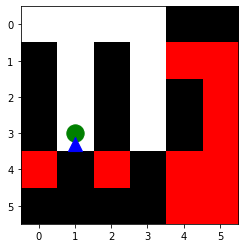

47. turn right


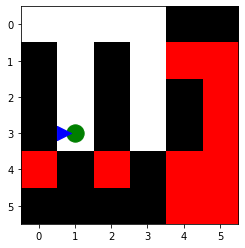

48. turn right


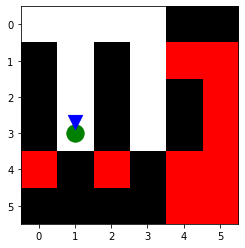

49. walk ahead


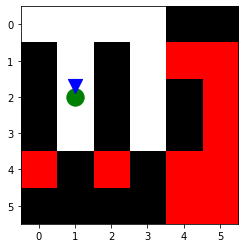

50. walk ahead


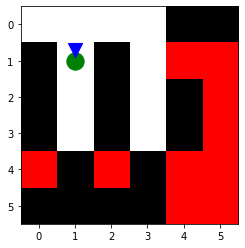

51. walk ahead


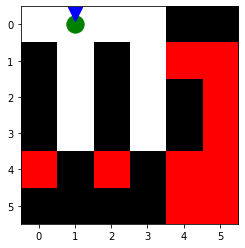

52. take a left


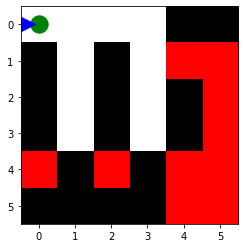

53. turn right


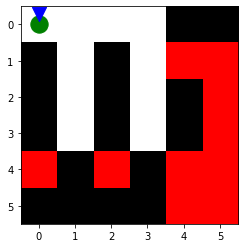

54. turn right


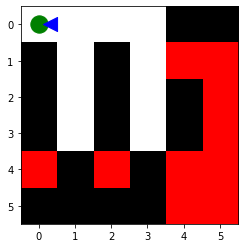

55. walk ahead


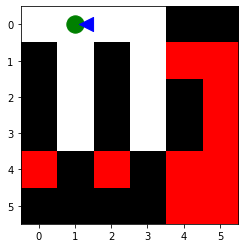

56. walk ahead


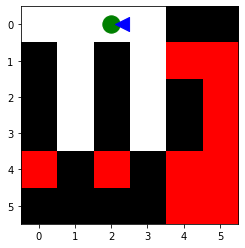

57. walk ahead


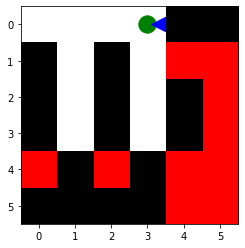

58. turn right


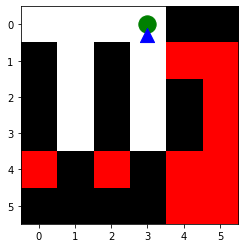

59. walk ahead


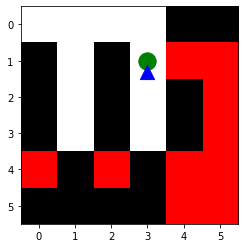

60. take a left


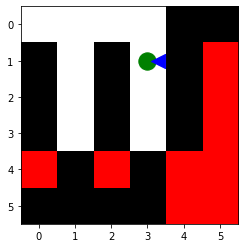

61. take a left


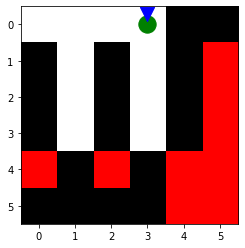

62. take a left


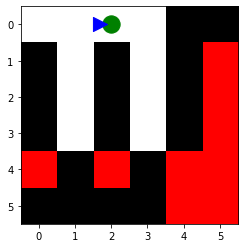

63. walk ahead


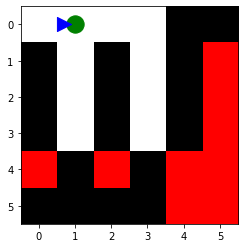

64. take a left


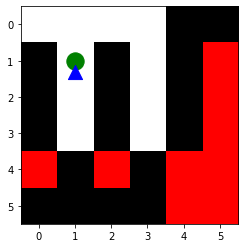

65. walk ahead


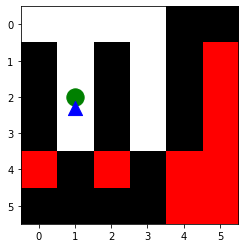

66. walk ahead


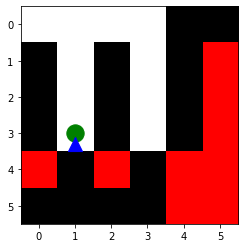

67. turn right


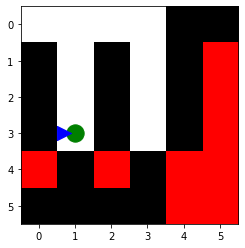

68. turn right


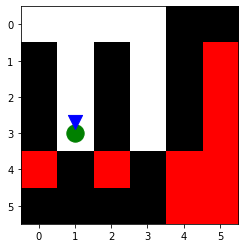

69. walk ahead


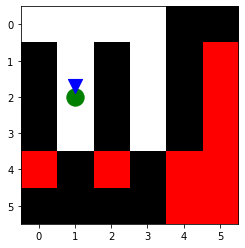

70. walk ahead


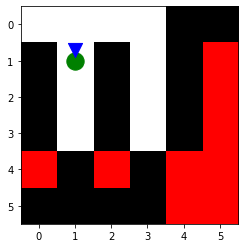

71. walk ahead


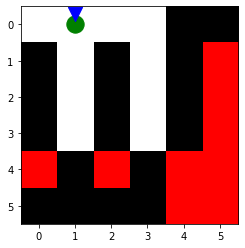

72. take a left


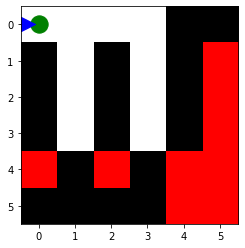

73. turn right


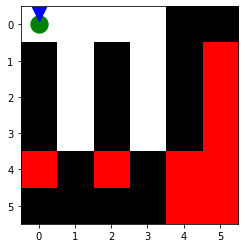

74. turn right


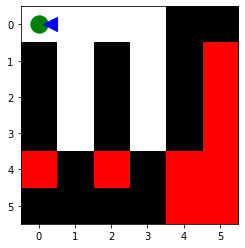

75. walk ahead


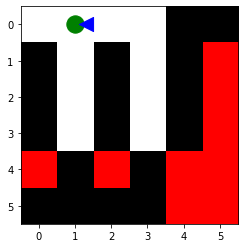

76. walk ahead


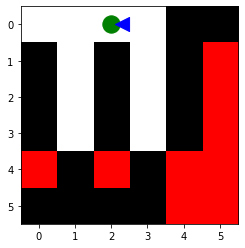

77. walk ahead


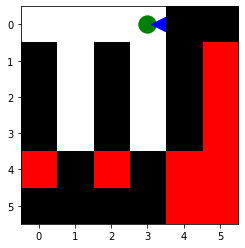

78. turn right


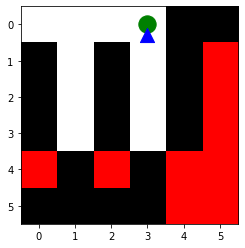

79. walk ahead


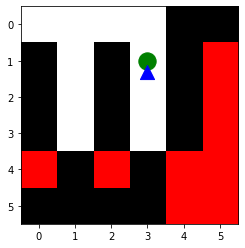

80. walk ahead


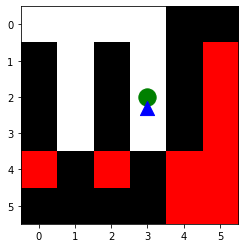

81. walk ahead


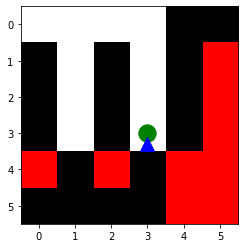

82. turn right


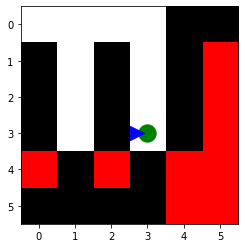

83. turn right


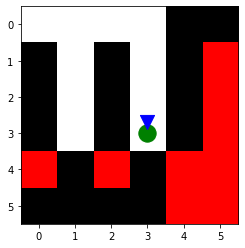

84. walk ahead


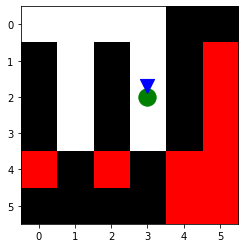

85. walk ahead


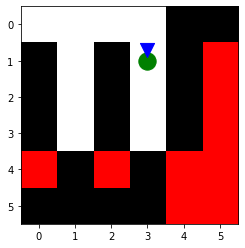

86. walk ahead


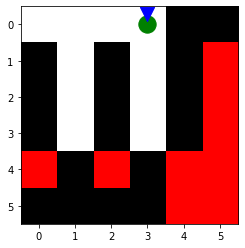

87. take a left


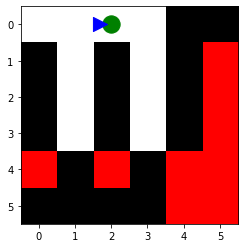

88. walk ahead


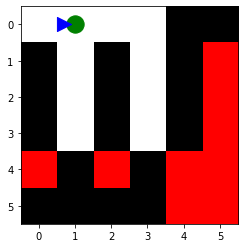

89. take a left


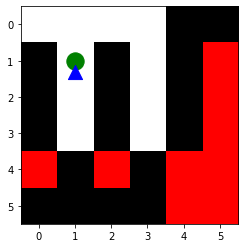

90. walk ahead


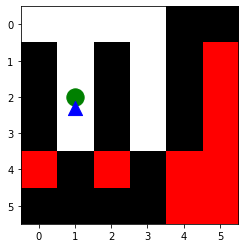

91. walk ahead


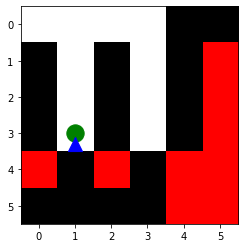

92. turn right


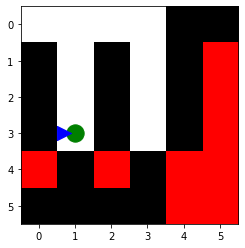

93. turn right


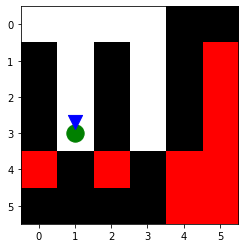

94. walk ahead


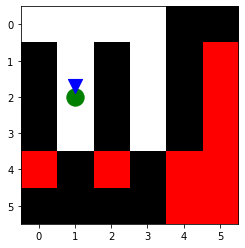

95. walk ahead


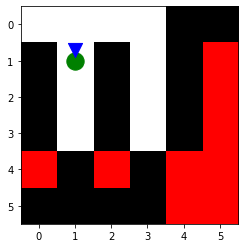

96. walk ahead


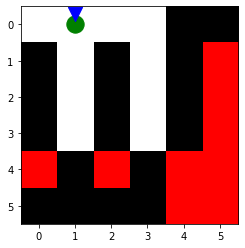

97. take a left


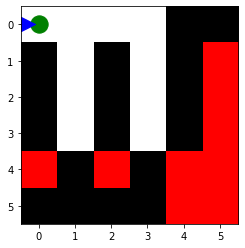

98. turn right


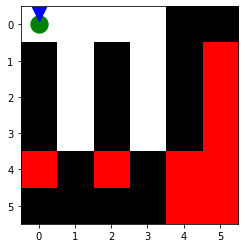

99. turn right


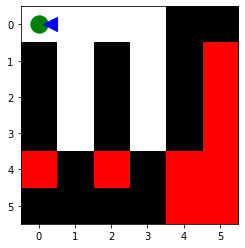

In [393]:
plot_maze()
state = dumb_strategy_2()

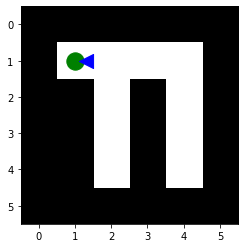

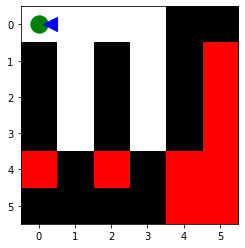

In [395]:
plot_maze()
plot_state(state)

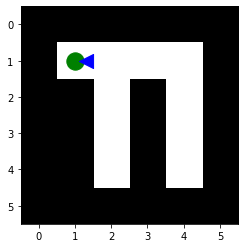

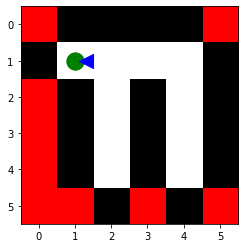

In [407]:
shift = [1,1]
rotation = None  # rotation to apply to match, luckily not the case here
state["maze"] = np.roll(state["maze"], shift, axis=[0,1])
state["position"] = state["position"] + np.array(shift)
plot_maze()
plot_state(state)

### Do it again with policy

In [416]:
def run_episode(policy, num_steps=20):
    """
    Walk ahead and turn left when facing a wall
    """
    plot_maze()
    
    state = init_state()
    update_ahead(state)
    plot_state(state)
    
    for step in range(num_steps):
        print(step, end=". ")
        action = policy(state)
        print("do", action)
        action_space[action]()
        update_maze(state, action)
        plot_state(state)
    
    return state

In [412]:
def walk(pos, direction):
    # doesn't check if out of map
    return pos + np.array([[-1,0],[0,1],[1,0],[0,-1]])[direction]
    
def dumb_policy_1(state):
    next_pos = walk(state["position"], state["direction"]) % size_maze
    if state["maze"][next_pos[0],next_pos[1]] == EMPTY:
        return "walk"
    else:
        return "left"

In [413]:
def dumb_policy_2(state):
    """
    Not the same as dumb_strategy_2
    """
    left_pos = walk(state["position"], (state["direction"]-1)%4) % size_maze
    if state["maze"][left_pos[0], left_pos[1]] == UNKNOWN:
        return "left"
    
    next_pos = walk(state["position"], state["direction"]) % size_maze
    if state["maze"][next_pos[0], next_pos[1]] == EMPTY:
        return "walk"
    else:
        return "right"

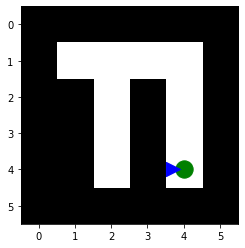

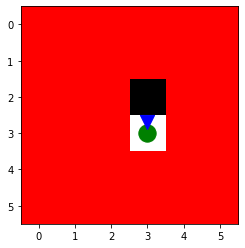

0. do left


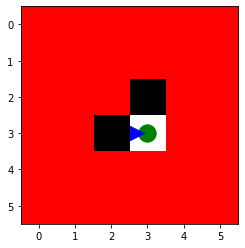

1. do left


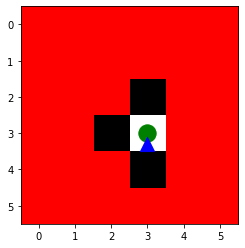

2. do left


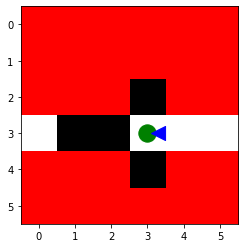

3. do walk


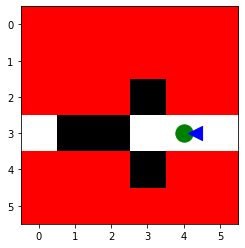

4. do left


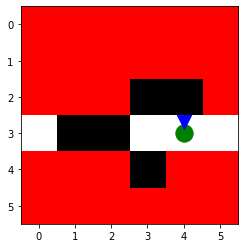

5. do right


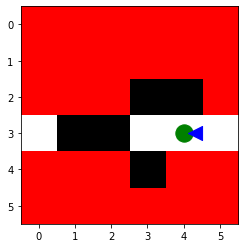

6. do walk


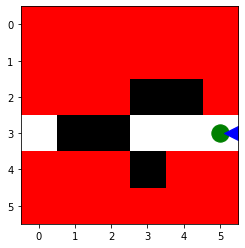

7. do left


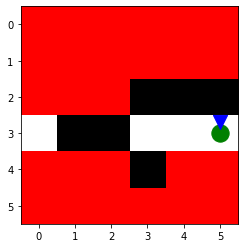

8. do right


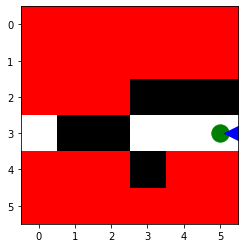

9. do walk


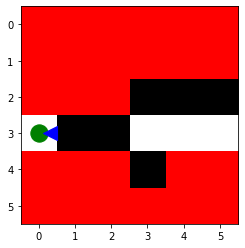

10. do left


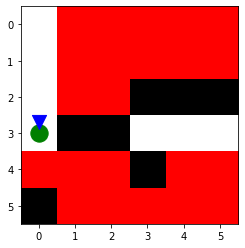

11. do walk


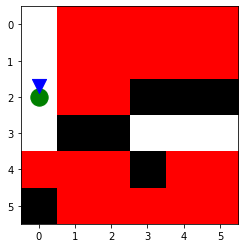

12. do walk


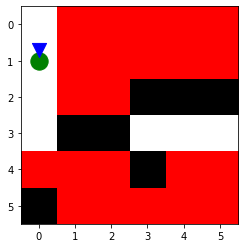

13. do left


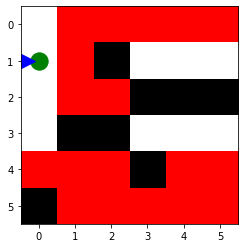

14. do walk


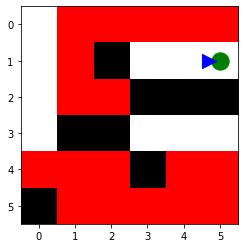

15. do walk


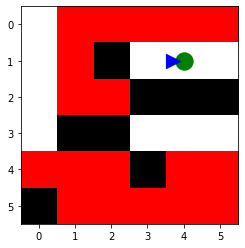

16. do walk


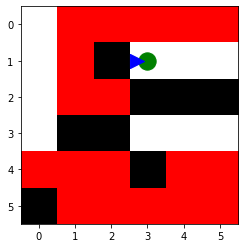

17. do right


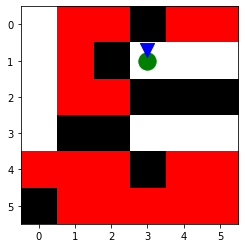

18. do right


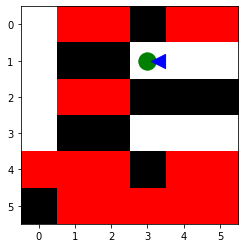

19. do walk


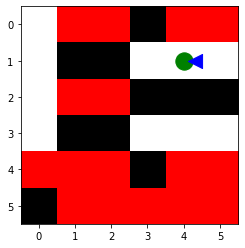

20. do left


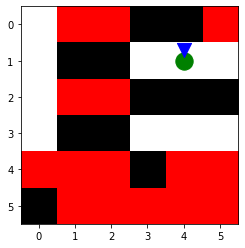

21. do right


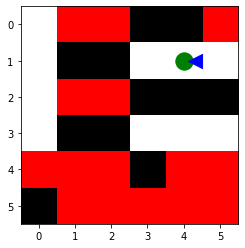

22. do walk


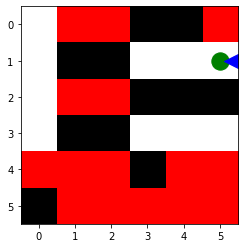

23. do left


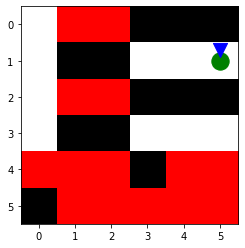

24. do right


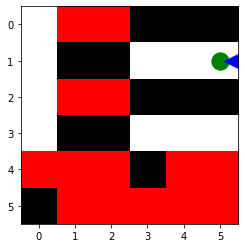

25. do walk


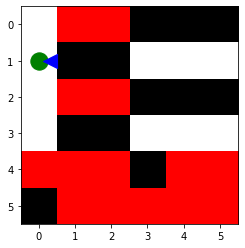

26. do right


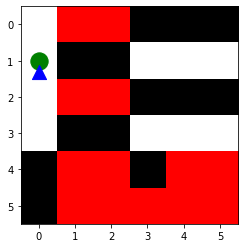

27. do walk


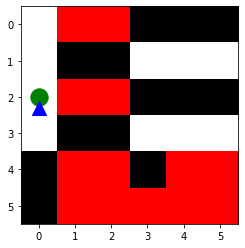

28. do left


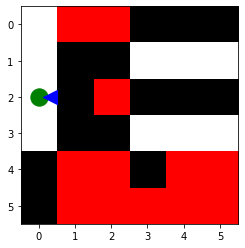

29. do right


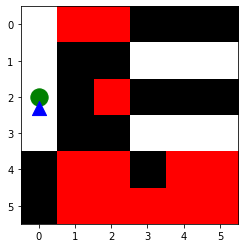

30. do walk


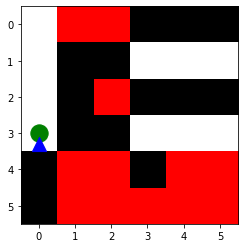

31. do right


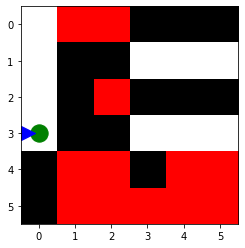

32. do walk


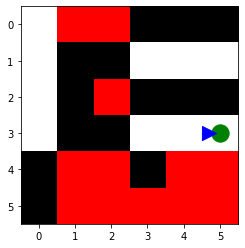

33. do left


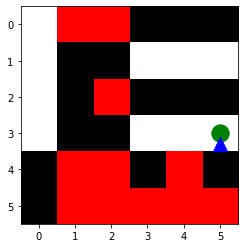

34. do right


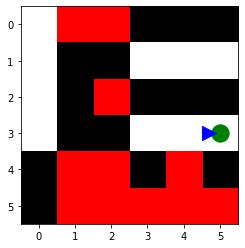

35. do walk


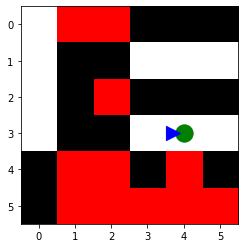

36. do left


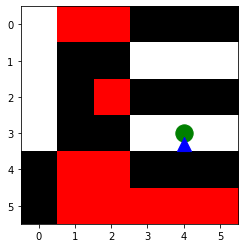

37. do right


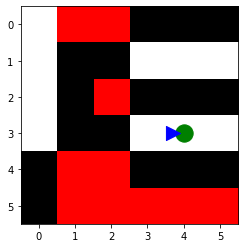

38. do walk


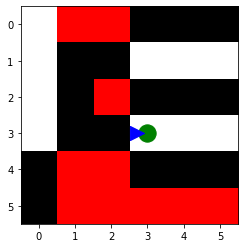

39. do right


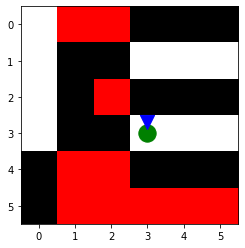

40. do right


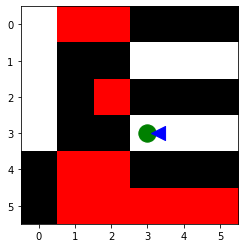

41. do walk


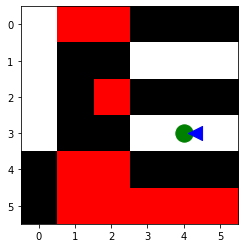

42. do walk


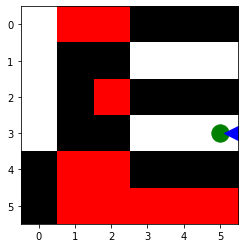

43. do walk


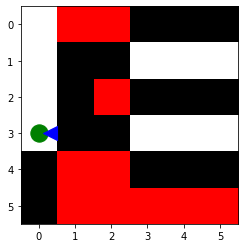

44. do right


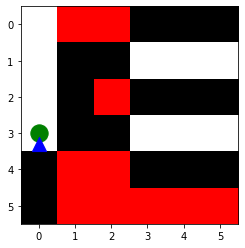

45. do right


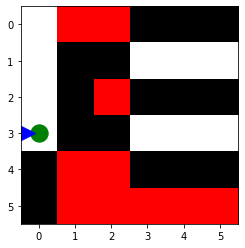

46. do walk


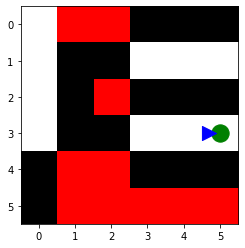

47. do walk


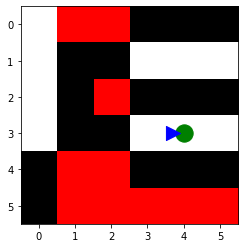

48. do walk


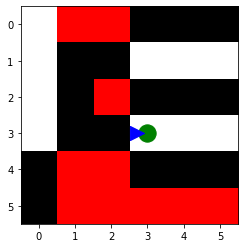

49. do right


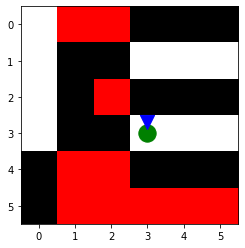

In [417]:
state = run_episode(dumb_policy_2, num_steps=50)

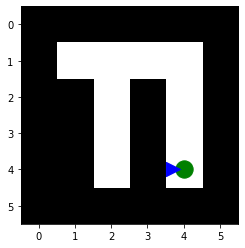

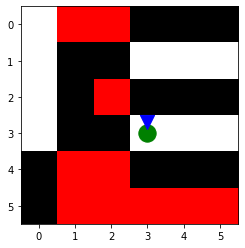

In [418]:
plot_maze()
plot_state(state)

In [419]:
from copy import deepcopy

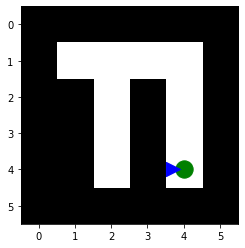

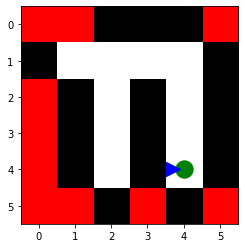

In [429]:
num_rot = 1
shift = [2,1]

state_copy = deepcopy(state)
for _ in range(num_rot):
    state_copy["maze"] = np.rot90(state_copy["maze"])
    pos = state_copy["position"]
    state_copy["position"] = [size_maze-1 - pos[1], pos[0]]
state_copy["maze"] = np.roll(state_copy["maze"], shift, axis=[0,1])
state_copy["direction"] = (state_copy["direction"] - num_rot) % 4
state_copy["position"] = state_copy["position"] + np.array(shift)

plot_maze()
plot_state(state_copy)